<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/%EC%98%81%EC%96%B4%EB%AA%A8%EB%8D%B8_SAM_WGAN_v3.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN based Korean summarizer using semi abstractive method


---
이훈석(1), 안순홍(2), 김승훈(교신)

---

# Abstract

 최근 NLP 분야는 encoder, decoder 및 attention을 거쳐 각종 transformer 모델이 나오면서 비약적인 발전을 이루고 있다. 문서 요약도 transformer에 의해 추상적인 요약이 가능해 졌다. 하지만 한국어의 경우, 양질의 대량 요약 학습셋이 갖추어져 있지 않아, 추상적인 요약 모델 개발 진행이 느리다. 비지도학습의 추출 요약을 사용할 수 있으나, 전반적 내용이 아닌 지협적 요약이 이루어진다는 단점이 있다. 이러한 단점을 극복하기 위해 본 연구에서는 요약 학습셋 없이 원문에서 요약에 필요한 어절을 추출하여 GAN 알고리즘에 의해 새로운 요약문을 생성하는 반추상적 방법 (Semi Abstractive Method, SAM) 을 제안한다. 
  실험에 의해 비지도학습으로 문서 전반적인 내용의 유사성과 문법의 정합성을 유지하며 요약이 되어짐을 확인하여 본 제안 방법의 우수성을 입증한다.  

Recently, the NLP field is making a leap forward with as various transformer models come out through encoder, decoder and attention. Document summarization is also possible for abstract summarization by transformer. However, in the case of Korean language, the development of abstract summary models is slow because there is no high-quality mass summary learning data set. An extractive summary method as a unsupervised learning can be used, but it has the disadvantage that an isthmus summary is made rather than the overall content. In order to overcome these obvious flaw, In this paper, we proposes a semi-abstractive method (SAM) that extracts words necessary for summary from the original text without a summary learning data set and generates a new summary by GAN algorithm. We show the distinction of this proposed method by demonstrating that it maintains the similarity of the overall contents of the document and the consistency of the grammar through experiments.


#1. Introduction

ref : https://www.machinelearningplus.com/nlp/text-summarization-approaches-nlp-example/

뉴스 사이트를 열 때 모든 뉴스 기사를 처음부터 끝까지 모두 읽지는 않습니다. 일반적으로 짧은 뉴스 요약을 살펴본 다음 관심이있는 경우 자세한 내용을 읽는다. 최근 잡지, 뉴스 애그리 게이터 앱, 조사 사이트 등과 같은 모든 곳에서 뉴스에 대한 짧고 유익한 요약이 제공된다.

중요한 정보를 잃지 않고 원본 거대한 텍스트에서 이러한 요약을 추출하는 방법을 텍스트 요약이라 한다. 요약은 문법적으로 읽기 편하며 중요한 것을 묘사하는 것이 필수적이다.

실제로 Google 뉴스, inshorts 앱 및 기타 다양한 뉴스 수집기 앱은 텍스트 요약 알고리즘을 활용하고 있다.

최근 요약 알고리즘의 트렌드에 대해 살펴본다.

When you open a news site, not all news articles are read from start to finish. In general, go through a short news summary and then read the details if you are interested. Short and informative summaries of news are available everywhere, such as in recent magazines, news aggregator apps, and research sites.

The method of extracting these summaries from the original large text without losing important information is called text summaries. The summary is grammatically easy to read and it is essential to describe what is important.

In fact, Google News, the inshorts app, and many other news aggregator apps utilize text summarization algorithms.

Let's look at the trend of the recent summary algorithm.

텍스트 요약 방법은 추출 방법과 추상 방법의 두 가지 주요 범주로 그룹화 할 수 있습니다.

> * 추출 텍스트 요약

> 먼저 개발 된 전통적인 방법으로서 주요 목표는 텍스트의 중요한 문장을 식별하고 요약에 추가하는 것이다. 얻은 요약에는 원본 텍스트의 정확한 문장이 포함되어 있다는 점에서 많이 활용되고 있다.

> * 추상적인 텍스트 요약

> 그것은 더 진보 된 방법이며, 최근 많은 연구가 진행되고 있다. 접근 방식은 중요한 섹션을 식별하고 컨텍스트를 해석하며 새로운 방식으로 재생산하는 것이다. 이렇게하면 핵심 정보가 가능한 가장 짧은 텍스트를 통해 전달된다. 여기서는 원본 텍스트에서 추출한 문장이 아니라 요약 된 새로운 문장이 생성된다.

본 논문에서는 추상적인 텍스트 요약 방법으로서 원문에서 문장이 아닌 어절 단위로 추출하여 적절한 문법적 흐름과 원문의 내용을 포함한 새로운 문장들을 생성하므로 원본 텍스트를 요약하고자 한다.


Text summary methods can be grouped into two main categories: extractive methods and abstractive methods.

> * Extractive text summary

> As a traditional method developed first, the main goal is to identify important sentences in the text and add them to the summary. The summary obtained is widely used in that it contains the exact sentence of the original text.

> * Abstractive text summary

> It is a more advanced method, and a lot of research is currently underway. The approach is to identify important sections, interpret context, and reproduce in new sentences. In this methods, key information is conveyed through the shortest possible text. In this approach, a new summary sentence is created, not the sentence extracted from the original text.

In this paper, as an abstractive text summary method, the original text is summarized by extracting the original text in terms of words, not sentences, and generating new sentences including the proper grammatical flow and contents of the original text.

#2. Related Work

먼저 추출 방법에 대한 기존 연구들을 살펴 보면 다음과 같다.

> Luhn [4]는 1960 년 Hans Peter Luhn에 의해 개발된 방법으로서 TF-IDF (Term Frequency-Inverse Document Frequency)를 기반으로 문장의 중요도를 채점하여 상위 점수의 문장을 추출하는 방식이다. 
> 이러한 개념을 발전시켜 2004년 Rada Mihalcea and Paul Tarau에 의해 TextRank[1] 방법과  G¨une¸s Erkan에 의해 LexRank [2] 추출 알고리즘이 개발되었다.
> 이후 2005년 Susan T. Dumais에의해 LSA [3] (잠재적 의미 분석) 라는 비지도 학습 알고리즘이 개발되었다. 이는 용어 문서 빈도 행렬에 SVD (Singular Value Decomposition)를 적용하여 의미 론적 의미 문장을 추출한다.
> KL-Sum [5] 은 Aria Haghighi에 의해 2009년 개발 되었다. 원문의 단어 분포와 문장별 단어 분포의 KL-divergence을 계산하여 문장을 선택한다. 

First, looking at the existing studies on the extraction method are as follows.

Luhn [4], a method developed by Hans Peter Luhn in 1960, is a method of extracting the highest scored sentences by scoring the importance of sentences based on TF-IDF (Term Frequency-Inverse Document Frequency). By developing this concept, the TextRank [1] method and the LexRank [2] extraction algorithm were developed by Rada Mihalcea and Paul Tarau in 2004 and by G¨une¼s Erkan. In 2005, Susan T. Dumais developed an unsupervised learning algorithm called LSA [3] (Potential Semantic Analysis). This extracts semantic semantic sentences by applying SVD (Singular Value Decomposition) to the term document frequency matrix. KL-Sum [5] was developed in 2009 by Aria Haghighi. A sentence is selected by calculating the KL-divergence of the word distribution in the original text and the word distribution by sentence.


하지만, 문서 일부 문장의 발췌만으로는 문서 전반적 내용을 포함하는 요약은 할 수는 없다. 
추상적인 요약은 전체 텍스트를 가장 잘 표현할 수있는 새로운 문장을 생성하는 새로운 최첨단 방법입니다. 
이것은 요약을 위해 원본 텍스트에서 문장을 선택하는 추출 방법보다 인간의 요약에 가까운 내용을 만들어 낸다.

> 추상적인 요약은 사실 원문의 문맥이 파악되어야 한다. NLP의 연구에서 문맥이 파악되는 중요한 단계는 바로 2014년에 발표됐던 sequence-to-sequence (Seq2seq)와 Attention 모델이다. (Sutskever et al., 2014, Cho et al., 2014). 이 모델을 기초하여 수많은 개념들이 연구되어 왔다. 이후,  Transformer 모델이 2017년 Google에 의해 소개되며 NLP 학계의 큰 주목을 받게된다. 이는 기존의 CNN 과 RNN 이 주를 이뤘던 연구들에서 벗어나 아예 새로운 모델을 제안하며 Seq2seq와 Attention, 이어 기계번역 성능을 한차원 높일 수 있었기 때문이다.
> 추상적인 요약은 긴 문장을 짧은 문장으로 바꾸는 일종의 기계 번역의 차원으로 다루고 있다. 따라서, 일반적으로 GPT-2, GPT-3, BERT, OpenAI, GPT, T5와 같은 각종 Transformer 모델에서 추상적인 요약 방법이 응용되고 있다.

Abstract summarization is a new state-of-the-art method of generating new sentences that best represent the entire text. This produces a content closer to human summary than the extraction method of selecting sentences from the original text for summary purposes.

> For abstract summaries, in fact, the context of the original text must be grasped. An important step in understanding the context in NLP's research is the sequence-to-sequence (Seq2seq) and Attention model, which was released in 2014. (Sutskever et al., 2014, Cho et al., 2014). Numerous concepts have been studied based on this model. After that, the Transformer model was introduced by Google in 2017 and received great attention from NLP academia. This is because we were able to improve machine translation performance to the next level, following Seq2seq and Attention, by proposing a new model, breaking away from the studies that were dominated by the existing CNN and RNN.

> Abstract summarization is treated as a kind of machine translation that turns long sentences into short sentences. Therefore, in general, abstract summary methods are applied in various Transformer models such as T5[6] (ref : Colin Raffel. (2020). Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer, https://arxiv.org/pdf/1910.10683.pdf), BART Transformer [7] (ref : Mike Lewis, (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension, https://arxiv.org/pdf/1910.13461.pdf), GPT-2 Transformers [8] (ref : Alec Radford, (2018). Language Models are Unsupervised Multitask Learners, https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), XLM Transformers [9] (ref : Guillaume Lample, (2019). Cross-lingual Language Model Pretraining, https://arxiv.org/pdf/1901.07291.pdf)

또한 원문을 '원본'으로 보고 요약을 원문에 대한 '모조'의 개념으로 보면, GAN 학습 알고리즘 또한 추상적인 요약의 주요 뼈대를 이루는 방법론이라 할 수 있다.

> 문장 생성기 출력을 사람이 읽을 수 있도록 만들기 위해 GAN 알고리즘을 적용하는 연구들이 있었다. GAN을 문장 생성에 적용하는 데있어 가장 큰 문제는 자연어의 이산 적 특성입니다. 단어 시퀀스를 생성하기 위해 생성기는 일반적으로 argmax 또는 matching과 같은 원래의 GAN 알고리즘에 대해 실패를 유발하는 기타 샘플 함수와 같은 비차 등 부분을 가지고 있다.
(Gulrajani et al., 2017)에서 저자는 개별 단어 시퀀스를 제공하는 대신 생성기 출력 레이어를 판별기에 직접 제공합니다. 이 방법은 이산 분포와 연속 분포 사이의 거리를 평가할 수있는 (Arjovsky et al., 2017)에서 제안한대로 GAN에서 Earth Mover (EM) distance를 사용하기 때문에 효과적입니다.
SeqGAN (Yu et al., 2017)은 강화 학습으로 시퀀스 생성 문제를 다룹니다. 여기서는이 접근 방식을 적대적 REINFORCE라고합니다. 그러나 판별 기는 전체 시퀀스의 품질 만 측정하므로 보상이 극히 드물고 모든 생성 단계에 할당 된 보상이 모두 동일합니다. MC search (Yu et al., 2017)는 각 시간 단계에서 대략적인 보상을 평가하기 위해 제안되었지만이 방법은 높은 시간 복잡성을 가지고 있습니다.
이 아이디어에 따라 (Li et al., 2017)는 각 시간 단계에서 예상되는 보상을 평가하기위한 부분 평가 접근법을 제안했었다.

 Looking at the original text as the 'original' and the summary as the concept of 'imitation' of the original text, the GAN learning algorithm can also be said to be a methodology that forms the main framework of the abstract summary.

> There have been studies of applying the GAN algorithm to make the output of the sentence generator human-readable. The biggest problem in applying GAN to sentence generation is the discrete nature of natural language. To generate a word sequence, the generator usually has parts such as non-differences, such as argmax or other sample functions that cause failures against the original GAN algorithm, such as matching.
In (Gulrajani et al., 2017), the author provides a generator output layer directly to the discriminator instead of providing individual word sequences. This method is effective because it uses the Earth Mover (EM) distance in GAN, as suggested by (Arjovsky et al., 2017), which allows you to evaluate the distance between the discrete and continuous distributions.
SeqGAN (Yu et al., 2017) deals with sequence generation problems with reinforcement learning. This approach is referred to here as hostile REINFORCE. However, since the discriminator only measures the quality of the entire sequence, the rewards are extremely rare and the rewards assigned to all stages of creation are all the same. MC search (Yu et al., 2017) was proposed to evaluate the approximate reward at each time step, but this method has a high time complexity.
Following this idea (Li et al., 2017) had proposed a partial assessment approach to assess the expected reward at each time step.

이상에서 설펴본 바와 같이, Transformer와 GAN 기법의 머지를 통해 비지도학습적 추상적인 요약을 실현 할 수 있을 것으로 착안하였다. 다음 섹션에서 Transformer를 사용하여 discriminator를 구현하고 GAN 기법에 의해 Generator를 학습하는 본 논문에서 제안하는 요약 방법을 설명한다.


As discussed above, it was conceived that unsupervised learning abstract summarization could be realized through merging of Transformer and GAN techniques. In the next section, we describe a summary method proposed in this paper that implements a discriminator using a transformer and learns a generator using a GAN technique.

#3. Proposed Method

본 논문에서 제안하는 방법은 Extractive 방식을 조합한 Semi Abstractive method라 할 수 있다. 원문을 어절별로 모두 나누고 이를 재조합하여 전체 내용을 요약한 몇개의 문장을 생성한다.

 이를 위해, Generator는 원문 어절의 개수 만큼의 noise를 input으로 받으며 
원문 어절의 개수 만큼의 output을 갖는다. 이때 output은 각 원문의 어절이 요약에 활용되는 확율값에 해당한다. 따라서, 특정 확율값 또는 주어진 어절의 개수에 해당하는 상위 순위의 확률값에 해당하는 어절을 선택하여 요약문을 생성한다. Similarity function에 의해서 원문으로부터 골자 어절들(frame terms)을 추출하고 이를 Generator에 bias로 입력한다. 이를 통해 Generator는 주요 어절들에 높은 확률값을 우선 할당하며, 이후 한국어 문법 discriminator에 의해 임의 생성된 문장이 문법적으로 사람이 읽을 수 있는 문장인지 구분한다. 또한 원문 유사성을 구분하는 유사도 discriminator에 의해 임의 생성된 문장이 원문 내용과 상이하지 않도록 조정한다.
전체 아키텍처는 아래 그림과 같다. 


The method proposed in this paper can be called a semi abstractive method that combines the extractive method. Divide the original text by word and reassemble it to create several sentences that summarize the entire contents.

For this purpose, the Generator receives noise as much as the number of original words as input and has output as much as the number of original words. And then, the output corresponds to the probability value used for summarizing the words of each original text. Therefore, a summary sentence is generated by selecting a word corresponding to a specific probability value or a probability value of the highest ranking corresponding to the number of given words. Frame words are extracted from the original text by similarity function and these are input as bias to the generator. Through this, the Generator first allocates a high probability values to the frame words, and then identifies whether the randomly generated sentences by the Korean grammar discriminator are grammatically human-readable sentences. Also, the similarity, which distinguishes the similarity of the original text, is adjusted so that the randomly generated sentences by the discriminator do not differ from the original text. The overall architecture is shown in the figure below.

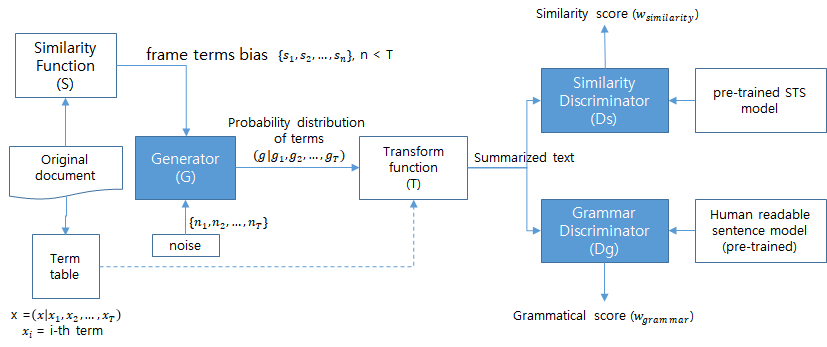

##3.1 Similarity function을 이용한 frame word의 추출

Document를 word 단위(여기서 말하는 word 단위는 띄어쓰기 단위를 의미)로 나눈다. 각각의 word을 xi 라고 할 때 Document는 다음과 같이 나타낼 수 있다.

Document

Split the document into word units (the word unit here means spaces). When each word is called xi, the document can be expressed as follows.

Document

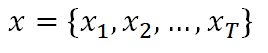


각 word에 대한 전체 document의 Similarity Probability Distribution (SPD)는 아래와 같이 나타낼 수 있다

The Similarity Probability Distribution (SPD) of the entire document for each word can be expressed as follows.


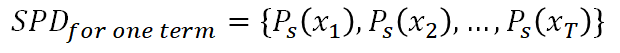


이를 연속적 Signal 이라 보고, Signal의 peak에 해당하는 word을 추출하여 이를 전체 document의 요약에 해당하는 frame words으로 구성하고자 한다.

그러나 document story상, 예를 들어 주인공을 지칭하는 word의 경우 전체 Similarity에 지배적 영향을 주게되고 signal의 peak는 해당 word들로만 구성 될 수가 있다. 결국, 원하는 frame을 얻지 못하게 된다. 이를 극복하기 위한 방법으로 복수의 words으로 구성된 story line의 SPD를 산출하여 사용한다. 만약 2개의 word인 경우 Similarity Probability는 다음과 같다.

This is regarded as a continuous signal, and a word corresponding to the peak of the signal is extracted, and it is composed of frame words corresponding to the summary of the entire document.

However, in the document story, for example, a word that refers to the protagonist has a dominant effect on the overall similarity, and the peak of the signal can consist only of the corresponding words. Eventually, the desired frame cannot be obtained. As a way to overcome this, the SPD of a story line composed of multiple words is calculated and used. If it is two words, the similarity probability is as follows.


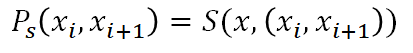


이때, 

At that moment,


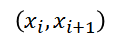

 의 구성은 일종의 Partial story 로서 filter의 역할을 하고, 전체 document를 convolution 한다.
만약 N개의 word을 filter로 사용한다면, 

The composition of this is a kind of Partial story that acts as a filter and convolutions the entire document.
If you use N words as a filter,

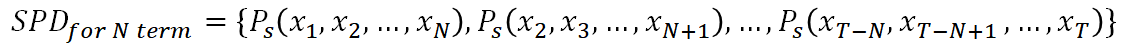


과 같이 된다. 

m개의 filter를 이용하여 frame words = s 를 아래와 같이 구성한다면

If frame words = s are composed as follows using m filters


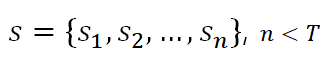



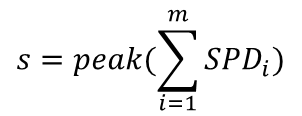


하지만 여기서 문제점은 SPD1~m 에서도 역시 주인공과 같은 지배적 word에 peak가 몰리고 story line에 해당하는 frame이 추출되지 못 할 수 있다는 것이다. 이를 극복하기 위해, peak를 추출하기 전에 SPD1의 값을 빼서 지배적 word의 peak를 회피하고 story line에 해당하는 frame을 추출 할 수 있도록 한다.


However, the problem here is that even in SPD1~m, the peak is concentrated in the dominant word like the main character, and the frame corresponding to the story line may not be extracted. To overcome this, before extracting the peak, the value of SPD1 is subtracted to avoid the peak of the dominant word, and the frame corresponding to the story line can be extracted.


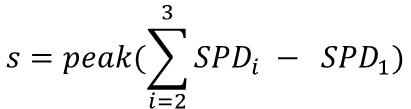

###3.1.1 Similarity function, S (Sentence-BERT)

(ref :Nils Reimers and Iryna Gurevych, (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks ,https://arxiv.org/pdf/1908.10084.pdf)
를 기반으로 구현한다.

<font color='red'>BERT (Devlin et al., 2018) is a pre-trained transformer network (Vaswani et al., 2017), which set for various NLP tasks new state-of-the-art results, including question answering, sentence classification, and sentence-pair regression. The input for BERT for sentence-pair regression consists of the two sentences, separated by a special [SEP] token. Multi-head attention over 12 (base-model) or 24 layers (large-model) is applied and the output is passed to a simple regression function to derive the final label. Using this setup, BERT set a new state-of-the-art performance on the Semantic Textual Similarity (STS) benchmark (Cer et al.,2017). RoBERTa (Liu et al., 2019) showed, that the performance of BERT can further improved by small adaptations to the pre-training process. and the XLNet (Yang et al., 2019) is also widely used., but it led in general to worse results than BERT. </font>

Sentence-BERT(SBERT), a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. <font color='red'>This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT. </font>

SBERT를 활용할 수 있는 pretrained model은 https://www.sbert.net/docs/pretrained_models.html 여기서 확인 할 수 있다.

본 논문에서는  한국어로 학습된 'xlm-r-large-en-ko-nli-ststb' 모델을 사용하였고, 이 모델의 STS Benchmark score는 84.05% 이다.

Pretrained models that can utilize SBERT can be found here: https://www.sbert.net/docs/pretrained_models.html.

In this paper, the'xlm-r-large-en-ko-nli-ststb' model learned in Korean was used, and the STS Benchmark score of this model was 84.05%.

SBERT를 구현한 python 라이브러리인 sentance-transformer package를 사용하여 Similarity function을 구현 하였다. 본 라이브러리는 BERT기반의 모델들과 유사하게 입력 limit가 있다. maximum 128 tokens을 입력할 수 있으며 1024 차원의 embedding된 vector를 반환한다. 즉, 전체 문서에 대해서 한번에 embedding할 수는 없으며, 이를 해결하기 위해 문서를 문장별로 나누어 N개의 문장에 대해 (N,1024)의 행렬로 embedding 하였다. similarity를 측정하기 위한 문장에 대해서도 (n,1024) 행렬화 하여 pair-wise하게 cosin distance를 계산한 (n,N) 행렬을 취득한 후 각 행별 최소값에 대한 평균값을 통해, 전체 문서에 대한 Similarity를 산출 하였다. 

Similarity function was implemented using sentance-transformer package, a python library implementing SBERT. Similar to BERT-based models, this library has an input limit. The input accepts a maximum of 128 tokens and returns a 1024-dimensional embedding vector. That is, it is not possible to embedding the entire document at once, and to solve this problem, the document is divided by sentence and embedding in a matrix of (N, 1024) for N sentences. After matrixing the sentences for measuring similarity (n,1024), the cosin distance is calculated pair-wisely to obtain the (n,N) matrix. After that, the average value of the minimum value for each row was taken, and the similarity for the entire document was calculated.

##3.2 keyBERT을 이용한 frame term의 추출

ref:Sharma, P., & Li, Y. (2019). Self-Supervised Contextual Keyword and Keyphrase Retrieval with Self-Labelling. https://www.preprints.org/manuscript/201908.0073/download/final_file

##3.3 한국어 문법 Discriminator, D

https://analyticsindiamag.com/how-to-use-bert-transformer-for-grammar-checking/

<font color='red'>
Jacob Devlin, (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
</font>

<font color='red'>* Impact of the BERT model<br>
BERT is a language representation model trained by huge data, huge models, and enormous computational overhead. It is optimal in 11 natural language processing tasks (state-of-the-art) , SOTA) results. It is estimated that many people will ridicule experiments of this scale, which are basically out of reach for general laboratories and researchers, but it does give us a lot of valuable experience. The reason for the high-performance of the BERT model is due to two points. In addition to the improvement of the model, it is more important to use a large data set (BooksCorpus 800M + English Wikipedia 2.5G words) and a large computing power. Pre-training on related tasks, achieving monotonous growth in performance on target tasks.

* Overview of Task<br>
Now the task which we are to do is to predict whether a sentence is grammatically correct or not. We choose a dataset in which we are given a piece of text and along with it a label .which is referred to as the “whether it is grammatically correct or not”.<br>
0 means grammatically incorrect and 1 means grammatically correct.<br>
So essentially this problem translates into a text classification problem where we classify whether a sentence is grammatically correct or not.
* Getting started with Modeling<br>
We’ll use [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It’s a set of sentences labelled as grammatically correct or incorrect. It was first published in May of 2018 and is one of the tests included in the “GLUE Benchmark” on which models like BERT are competing </font>


한국어 문법의 정합성을 구분하기 위해 BERT기반 문장 classification을 구성한다. 한국어 pre-trained model 'monologg/kobert' 을 기반으로 약 3만개의 한국어 단일 문장을 fine-tunning 하였다. 정상 문장의 경우 label = 1, 문법적으로 비정상 문장은 label = 0 으로 labeling하였으며, 비정상 문장은 단순하게 정상문장을 shuffling 해서 만들었다. epoch 4회, 3천개의 validation set으로 성능 측정결과 F1 score 0.99가 나왔다.

In order to classify the consistency of Korean grammar, we construct BERT-based sentence classification. About 30,000 Korean single sentences were fine-tuned based on the Korean pre-trained model'monologg/kobert'. For normal sentences, label = 1, grammatically abnormal sentences were labeled as label = 0, and abnormal sentences were made by simply shuffling the normal sentences. As a result of measuring the performance with epoch 4 times and 3,000 validation sets, an F1 score of 0.99 was obtained.

## 3.4 한국어 Text Generator, G

Text Generator는 단순화 하기 위해 일반 DNN을 사용하였다. 원문의 전체 words의 개수에 해당하는 random noise와 Frame words를 bias로 입력받는다. 즉, 입력항이 2개이며 Output은 어떤 word가 요약에 사용될지 모르기 때문에 입력과 동일하게 원문 전체 word의 개수와 같다.

Text Generator used general DNN for simplification. Random noise and frame words corresponding to the total number of words in the original text are input as a bias. That is, there are two input terms and the output is equal to the number of words in the original text as it is the same as the input because we do not know which word will be used for the summary.


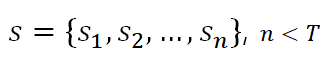

random noise 는 dense layer 몇 개를 거치지만 Frame words bias는 동일 차원의 output 바로 직전에 deep network의 output tensor에 add 된다. 이로서 전체 output은 frame words에 bias 되어 원문이 요약된 문장이 생성된다. 또한 random noise에 의해 frame words 각각의 사이에 적절한 word가 원문에서 추출 되는 것이다. 이후, 생성된 probability distribution (Output)에서 요약에 사용되는 word는 아래의 조건에 의해서 선택된다.

Random noise goes through several dense layers, but frame words bias is added to the output tensor of the deep network just before the output of the same dimension. As a result, the entire output is biased to the frame words, and a sentence summarizing the original text is generated. Also, appropriate words between each frame words are extracted from the original text by random noise. Then, in the generated probability distribution (Output), the word used in the summary is selected according to the following conditions.


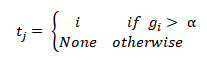

여기서 α 값을 조절 하므로 생성되는 text의 길이를 조절 할 수 있다. 적절한 α값을 통해 문법적으로 읽을 수 있는 글이 생성된다. 
마지막으로 선택된 t vector는 x에서 선택된 order에 해당되며 x[t] 연산에 의해서 text가 생성된다.


전체적인 구성은 아래와 같다. 

Here, you can adjust the length of the generated text by adjusting the α value. A text that can be read grammatically is generated through an appropriate α value.
Finally, the selected t vector corresponds to the order selected from x, and text is created by the x[t] operation.


The overall composition is as follows.

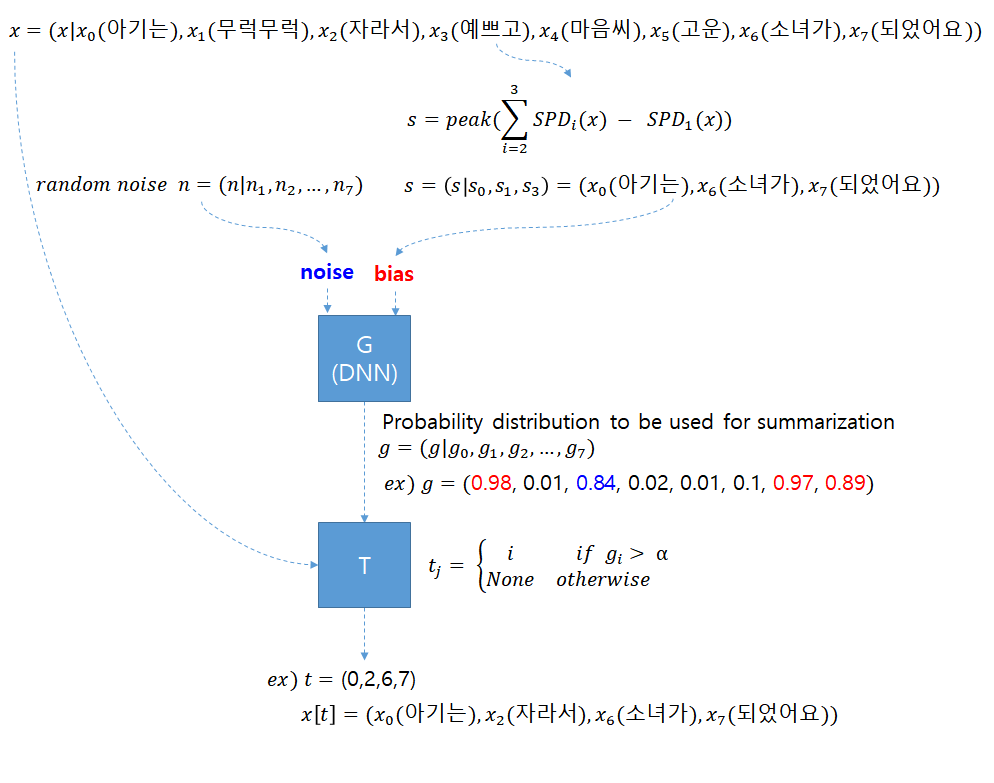

##3.5 GAN Training

GAN의 논문 (ref:Ian J. Goodfellow, (2014). Generative Adversarial Nets, https://arxiv.org/pdf/1406.2661.pdf) 에서 보면 value function V(G,D)에 대하여 다음을 만족시키는 과정에 의하여 학습이 이루어 진다.

In GAN's paper (ref:Ian J. Goodfellow, (2014). Generative Adversarial Nets, https://arxiv.org/pdf/1406.2661.pdf), the process that satisfies the following for value function V(G,D) Learning is achieved by

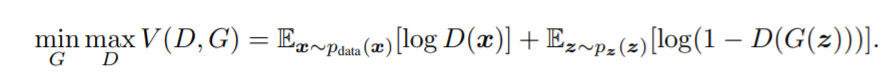

즉, D에 대한 cross-entory 

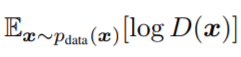

와 G에 대한 cross-entropy 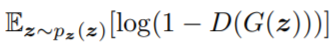

에 대한 최적화의 과정임을 알 수 있다.

본 논문에서 다루는 전체 목적함수는 아래와 같이 나타낼수 있다.


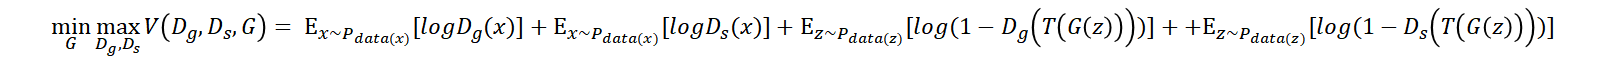

문제는 Discriminator 전에 Transform function T에 의해 G에서 생성한 probability distribution을 readable text 로 변환 하는 과정이 있는 것이다. 즉, T는 미분 불가능한 절차적 함수로서 D(T(G(z)))는 학습에 필요한 backward를 할 수 없다. 

이러한 문제는 GAN을 통한 Text 생성 알고리즘에서 빈번히 봉착하는 문제이며 논문 
(ref : Yau-ShianWang, (2018). Learning to Encode Text as Human-Readable Summaries using Generative Adversarial Networks) 에서는 'Self-Critic Adversarial REINFORCE'을 제안하였다. 해당 기법에서는 이산 시퀀스 ys를 판별기에 공급하기 때문에 판별 기의 기울기가 생성기로 직접 역 전파 할 수 없습니다. 여기에서는 정책 그라데이션 방법을 사용합니다. 타임 스텝 i에서, 우리는 식별기의 i ㆍ 1 타임 스텝 점수 si ㆍ 1를 자기 임계 기준선으로 사용합니다. 보상 rD i는 시간 단계 i의 시퀀스 품질이 시간 단계 i의 시퀀스 품질보다 더 좋은지 또는 더 나쁜지를 평가합니다. 1. D2의 생성자 보상 rD i는 다음과 같습니다.

The problem is that there is a process of converting the probability distribution generated in G into readable text by the transform function T before the discriminator. That is, T is a procedural function that cannot be differentiated, and D(T(G(z))) cannot perform backward required for learning.

These problems are frequently encountered in the text generation algorithm through GAN, and the paper (ref: Yau-ShianWang, (2018).Learning to Encode Text as Human-Readable Summaries using Generative Adversarial Networks) Suggested 'Self-Critic Adversarial REINFORCE'. In that technique generator feed a discrete sequence ys to the discriminator, the gradient from the discriminator cannot directly back-propagate to the generator. Here, we use the policy gradient method. At timestep i, we use the i 􀀀 1 timestep score si􀀀1 from the discriminator as its self-critical baseline. The reward rD i evaluates whether the quality of sequence in timestep i is better or worse than that in timestep i 􀀀 1. The generator reward rD i from D2 is

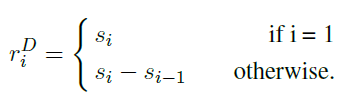

However, some sentences may be judged as bad sentences at the previous timestep, but at later timesteps judged as good sentences, and vice-versa. Hence we use the discounted expected reward d with discount factor to calculate the discounted reward di at time step i as


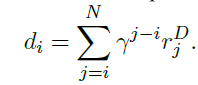

To maximize the expected discounted reward di, the loss of generator is:


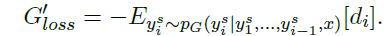


We use the likelihood ratio trick to approximate the gradient to minimize 

하지만 이러한 방식은 RNN에 의한 timeseries로 접근 할 때 가능하며, discounted reward d의 적용은 loss의 미분 폭이 매우 좁아서, 상당히 많은 시행 (epoch)과정이 필요하다.

따라서 본 논문에서는 cross-entropy를 loss로 사용하지 않고 변형된  wasserstein distance (Martin Arjovsky, (2017). Wasserstein GAN, https://arxiv.org/pdf/1701.07875.pdf)를 사용고자 한다. 

G(z)의 output (g|g1,g2,...gT)에 대하여 T 함수는 내부에 다음의 과정이 있다. 



We use the likelihood ratio trick to approximate the gradient to minimize

However, this method is possible when approaching the timeseries by RNN, and the application of discounted reward d has a very narrow differential width of the loss, requiring a considerable amount of epoch.

Therefore, in this paper, we intend to use the modified wasserstein distance (Martin Arjovsky, (2017). Wasserstein GAN, https://arxiv.org/pdf/1701.07875.pdf) without using cross-entropy as a loss.

For the output of G(z) (g|g1,g2,...gT), the T function has the following process inside.

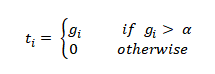

위에서 [알파]의 값은 요약 결과고 얻고자 하는 어절의 개수에 따라 결정된다. [알파]값이 크면 요약 결과 어절의 수가 작아지고 알파값이 작을 수로 요약 어절의 수가 많아 진다.

T(G(z))의 output의 예를 들면 다음과 같다.
(t|t1,t2,...tT) ~ (t|g1,0,0,g4,0,g6,...,0,gT)

이때
D(T(G(z))) = w

우리는 wasserstein distance을 loss로 사용하기 위해 

The value of [alpha] above is a summary result and is determined by the number of words to be obtained. The larger the [alpha] value, the smaller the number of words in the summary result, and the smaller the alpha value, the larger the number of summary words.

An example of the output of T(G(z)) is as follows. (t|t1,t2,...tT) ~ (t|g1,0,0,g4,0,g6,...,0,gT)

At this time, D(T(G(z))) = w

We use the wasserstein distance as the loss

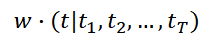

을 output으로 설정한다.

결과적으로 Generator의 loss는

Set to output.

As a result, the generator's loss is

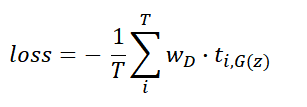

이렇게 함으로서 ti는 G의 output (g|g1...gT)의 일부로서, 미분가능 하고 backward를 통해 학습이 이루어 질 수 있다.

전체 목적 함수는 아래와 같다.

By doing this, ti is a part of G's output (g|g1...gT), which can be differentiated, and learning can be achieved through backward.

The overall objective function is as follows.

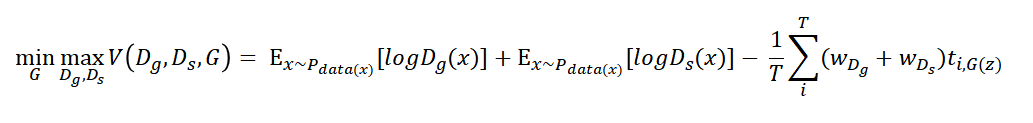

문법, 유사도 측정을 위한 각 Discriminator는 pre-trained model을 이용하여 일반화된 구분자로서 적용하였다.
그러나, 학습의 과정에서 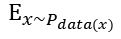

를 정의 할 수 없다. 이미, 요약된 실데이터를 만들수 없기 때문이다. 
그래서, 원문의 일부 문장을 대입하였더니, 학습이 진행되면서 원문의 일부로 overfitting 되는 경향이 나타났다. 즉, Extractive 방법의 결과로 수렴되는 것이다.
그래서, 본 논문에서는 Discriminator가 이미 pre-trained model에 의해 학습되어 있으므로 Discriminator를 학습에 참여 시키지 않았다. 따라서 최종 목적함수는 아래와 같이 단순화 하였다.

Each discriminator for measuring grammar and similarity was applied as a generalized delimiter using a pre-trained model. However, in the process of learning

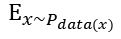


Cannot be defined. This is because it is not possible to create summarized real data already. So, after substituting some sentences from the original text, there was a tendency to overfitting as part of the original text as learning progressed. In other words, it converges as a result of the extractive method. So, in this paper, Discriminator was not involved in learning because the Discriminator has already been learned by the pre-trained model. Therefore, the final objective function is simplified as follows.

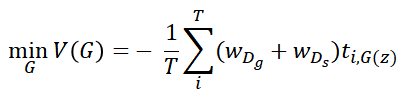

#4. Implementation


## 4.1 기본 설정...

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install keybert
!pip install sentence-transformers==0.3.0
!pip install transformers==3.0.2

#!pip install sentence-transformers

     |████████████████████████████████| 778kB 9.9MB/s 
     |████████████████████████████████| 1.2MB 21.4MB/s 
     |████████████████████████████████| 3.0MB 53.0MB/s 
  Found existing installation: tokenizers 0.10.1
    Uninstalling tokenizers-0.10.1:
      Successfully uninstalled tokenizers-0.10.1
  Found existing installation: transformers 4.3.3
    Uninstalling transformers-4.3.3:
      Successfully uninstalled transformers-4.3.3


In [4]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))

        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
        # Print New Line on Complete
        if self.ite == self.total: 
            print()

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

## CNN/Daily Mail dataset download...

In [10]:
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(name="cnn_dailymail",split=(tfds.Split.TRAIN,tfds.Split.TEST),with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.


In [11]:
train_data[0]

<PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>

In [12]:
sentences_dataset = []
gold_summary = []
iterator = iter(train_data[0])
for data in iterator:
    sentences_dataset.append(data['article'].numpy().decode('UTF-8'))
    gold_summary.append(data['highlights'].numpy().decode('UTF-8'))

In [13]:
print(sentences_dataset[0])

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained b

##4.2 Grammar Discriminator Class

In [14]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 40:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pre_trained_model_name='bert-base-uncased', input_dir=None):

        if input_dir is None:
            print('Loading BERT tokenizer...')
            self.tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name, do_lower_case=True)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pre_trained_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)



    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', self.tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sentences[0])))   

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                loss, logits = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    (loss, logits) = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizer.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        loss, logits = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return loss, logits


###4.2.1 CNN/Daily Mail dataset으로 영어 문법 학습

In [15]:
sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset[0:1])

In [16]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [17]:
k=5
print(labels[k])
sentences[k]

1


'The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month'

In [18]:
use_pretrained_model = True

if use_pretrained_model:
    g_discriminator = Grammar_Discriminator(input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammer_check_model')
else:
    sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()


Loading BERT tokenizer...


In [ ]:
    g_discriminator.set_dataset(sentences[0:500000],labels[0:500000])
    g_discriminator.train(epochs=1)
    g_discriminator.save_model()

 Original:  The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October
Tokenized:  ['the', 'bishop', 'of', 'the', 'fargo', 'catholic', 'diocese', 'in', 'north', 'dakota', 'has', 'exposed', 'potentially', 'hundreds', 'of', 'church', 'members', 'in', 'fargo', ',', 'grand', 'forks', 'and', 'jamestown', 'to', 'the', 'hepatitis', 'a', 'virus', 'in', 'late', 'september', 'and', 'early', 'october']
Token IDs:  [1996, 3387, 1997, 1996, 23054, 3234, 5801, 1999, 2167, 7734, 2038, 6086, 9280, 5606, 1997, 2277, 2372, 1999, 23054, 1010, 2882, 19896, 1998, 27435, 2000, 1996, 28389, 1037, 7865, 1999, 2397, 2244, 1998, 2220, 2255]
Original:  The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October
Token IDs: tens

##4.3 Static similarity discriminator class

In [19]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='stsb-roberta-large'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name)        

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  

###4.3.1 영어 문장 유사도 pre-trained model 적용

In [20]:
s_discriminator = Similarity_Discriminator(pre_trained_model_name="stsb-bert-base")
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


100%|██████████| 405M/405M [00:24<00:00, 16.8MB/s]


In [21]:
s_discriminator.encode('The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October.')

[array([ 2.27657720e-01, -6.99509531e-02, -5.11990666e-01,  9.85206338e-04,
         2.82677114e-01, -3.63664776e-01,  8.24765682e-01,  2.39037231e-01,
         6.24788761e-01, -2.99694717e-01,  5.15283883e-01, -2.26277277e-01,
         7.88181946e-02,  5.99584341e-01, -6.33385852e-02, -3.55492264e-01,
        -1.79062918e-01,  2.07268417e-01, -7.81623796e-02, -1.71789646e-01,
        -7.19511032e-01, -1.11096263e+00, -2.69686908e-01, -2.22545028e-01,
         3.87446582e-01,  8.80508721e-01,  1.79519475e-01, -4.77935791e-01,
        -1.63127095e-01,  2.46557429e-01, -2.46987745e-01,  4.96026605e-01,
        -8.17224085e-02, -8.87763262e-01, -3.62277329e-01,  1.72838792e-01,
        -4.18374896e-01, -4.08948779e-01, -7.15578020e-01,  7.36869574e-01,
         4.06240314e-01, -5.99188268e-01,  1.90909907e-01, -3.90087515e-01,
         6.66100562e-01, -3.09122711e-01, -5.58741450e-01,  5.65047622e-01,
         2.96891749e-01,  1.57496527e-01,  2.02111542e-01,  9.63748097e-02,
        -8.9

##4.4 Document source class

###4.4.1 keyBERT를 위한 pre-trained model의 적재

In [ ]:
from keybert import KeyBERT
key_model = KeyBERT('distilbert-base-nli-mean-tokens')

100%|██████████| 245M/245M [00:09<00:00, 24.5MB/s]


###4.4.2 frame term 추출을 위한 source class 구현

In [40]:


class Source:

    def __init__(self,org_text):
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()


    def extract_keywords(self,s_discriminator,key_model,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}
        index_table = {}
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)




        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='word density scan :')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #print('\n part_sen:',part_sen)
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='story density scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative words:',terms[dup_order])


        top_n = int(len(self.term_table) * comp_rate)

        self.story_peaks = []
        keywords = key_model.extract_keywords(org_text,top_n=top_n)
        print('keywords len',len(keywords))
        print('keywords',keywords)
        for keyword,p in keywords:
            for k in self.term_table.keys():
                if self.term_table[k] == keyword and k not in dup_order:
                    self.story_peaks.append(k)

        self.story_peaks.append(len(self.term_table)-2)
        self.story_peaks = np.sort(np.asarray(self.story_peaks))
        print('story_peaks:',self.story_peaks)
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame text:',self.frame_text)


    def analysis_frame_terms(self,s_discriminator,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0,comp_rate=0.2,except_key=True):

        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')


        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)

        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        if except_key:
            # story에 지배적인 word를 찾는다.
            # 먼저 word의 강세 분석
            for filter in word_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='word density scan :')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    word_weights[t] += score 

            # story의 강세 분석
            for filter in story_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='story density scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    story_weights[t] += score

            #각각의 peak를 산출
            word_peaks, _ = find_peaks(word_weights, height=0)
            story_peaks, _ = find_peaks(story_weights, height=0)

            #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
            #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
            #이를 통해 story에 대한 word를 최대한 추출 한다.

            dup_order = []
            for i in range(self.org_source_length):
                #lst = ""
                if (i in word_peaks) and (i in story_peaks):
                    if terms[i].endswith('.'):
                        pass
                    else:
                        dup_order.append(i)
                        
            # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
            print('Negative words:',terms[dup_order])
            if except_key:
                terms[dup_order] = '---'
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code         Token      ')
        print('')
        for index, word in zip(range(len(terms)),terms):
            print( f'  {str(index).ljust(8)}    {word}')
        print('---------------------------------------------')
        '''
        self.story_weights = np.zeros(self.org_source_length,)
        # 그리고 다시 story 분석 스캔
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='story density scan:')
            for conv in range(last_idx):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #part_sen = part_sen.replace('소녀','---')
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                self.story_weights[t] += score        


        # base line
        base_line = peak_base_line
        # 다시 peak 추출
        story_peaks, _ = find_peaks(self.story_weights, height=base_line)

        top_n = int(len(self.term_table) * comp_rate)

        if len(story_peaks) > top_n:
            peak_dict = {}
            for i,peak in zip(range(len(story_peaks)),story_peaks):
                peak_dict[peak] = self.story_weights[i]
            print(peak_dict)
            peaks = sorted(peak_dict, key=peak_dict.get, reverse=True)
            print(peaks)
            peaks = peaks[:top_n]
            print(peaks)
            peaks.sort()
            story_peaks = peaks
            print(story_peaks)

        print('top_n:',top_n,'story_peaks:',len(story_peaks))
        #print(story_peaks)
        
        self.story_peaks = np.append(story_peaks,len(story_weights)-2)
        print(self.story_peaks)
        # story density 표출
        plt.figure(figsize=(12, 6))
        plt.plot(self.story_weights)
        plt.plot(self.story_peaks, self.story_weights[self.story_peaks], "x")
        plt.plot(np.zeros_like(self.story_weights)+base_line, "--", color="gray")
        plt.show() 
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame text:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')      
        ''' 
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
   
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Score        Token              ')
        print('')
        for k in self.term_table.keys(): 
            print( f'  {str(k).ljust(5)}   {str(round(self.story_weights[k],4)).ljust(8)}  {self.term_table[k]}')

        print('---------------------------------------------') 
        '''
    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

##4.5 Generator class

In [23]:
from functools import reduce

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(input_size*2, input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*2),
            nn.LeakyReLU(0.2),

            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''
    def forward(self, x, story_peaks, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y_[:,story_peaks] += bias
        y_ = nn.Sigmoid()(y_)
        #reduce(torch.add, [y_,bias]) / 2
        return y_
    '''

    
    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

    '''    
    def forward(self, x):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        #y = torch.add(y_,bias)
        y = nn.Sigmoid()(y_)

        return y, y_    
    '''    

##4.6 Summarizer class (GAN training)

In [24]:
import random
import numpy as np


class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        self.s_discriminator = s_discriminator

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)

        return self

    def summarize(self,epochs=10,batch_size=2,frame_expansion_ratio = 0.8,init_bias = 1.0,learning_rate=2e-4):
        self.frame_expansion_ratio = frame_expansion_ratio
        history = self.__train(epochs,batch_size,init_bias,learning_rate)

        plt.figure(figsize=(12, 6))
        plt.plot(history['gen_g_loss'],label='generator grammar loss')
        plt.plot(history['gen_s_loss'],label='generator similarity loss')
        #if 'dis_loss' in history:
        #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
        plt.legend()
        plt.show()

        return self

    # text의 생성 for torch
    def __text_gen2(self, noise, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(noise, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __discrete_gradient(self,weights,gen_length,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)

        real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            gtext = self.__text_gen2(noise,gen_length)
            tw = ""
            tk = []
            fake_scores = []
            for (w,k) in gtext:
                tw += w + ' '
                tk.append(k)
                if w.endswith('.'):
                    fake_outs.append(tw.strip())
                    real_outs.append(real_text[i])
                    apply_order.append((i,tk))
                    tw = ""
                    tk = []
                    
            if len(tk) > 0:
                fake_outs.append(tw.strip())
                real_outs.append(real_text[i])
                apply_order.append((i,tk))

        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)
        D_x_loss, real_gmr_out=self.g_discriminator.transfer_learning(real_outs,train_for = True)   # not use of 'real_gmr_out'

        f_sim_out = []
        for fake_text in fake_outs:
            f_sim_out.append(self.s_discriminator.similarity(fake_text,self.source.org_text_emb))

        #if use_gpu:
        #    apply_order = torch.FloatTensor(apply_order).to(device)  
        
        #print(fake_dis_out)
        
        for j, (i,tk) in enumerate(apply_order):
            #fake_gen_out[i,tk] += fake_dis_out[j].numpy() --> 이거는 tf 용...
            #fake_gen_out[i,tk] += fake_dis_out[j] #.cpu().detach().numpy()
            # 
            try:
                #print('fake_gmr_out:',fake_gmr_out[j,1])
                #print('real_gmr_out:',real_gmr_out[j,1])
                #fake_gen_out[i,tk] += torch.sigmoid(fake_gmr_out[j,1])
                fake_gen_out[i,tk] += torch.tanh( fake_gmr_out[j,1])
                fake_sim_out[i,tk] += f_sim_out[j]
            except Exception as ex:
                print(j,i,tk)
                print(fake_gmr_out)
                raise ex

        return fake_gen_out, fake_sim_out, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10,init_bias = 1.0,learning_rate=2e-4):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = 10

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        D1_opt = AdamW(self.g_discriminator.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        self.bias_w = init_bias
        initial_bias = 0
        G_s_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)

        for i in range(epochs):
            '''
            noise = torch.randn(batch_size,self.source.org_source_length).to(device)
            bias = torch.zeros_like(noise).to(device)
            bias[:,self.source.story_peaks] += self.bias_w 
            with torch.no_grad():        
                sw, sw0 = self.generator(noise,bias)

            self.g_discriminator.discriminator.train()          #discriminator는 evaluation 모드로 전환
            fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
            
            D_loss = D_x_loss + D_z_loss      

            self.g_discriminator.discriminator.zero_grad()
            D_loss.backward()
            D1_opt.step()
            self.g_discriminator.discriminator.eval()
            '''
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device)
                bias = torch.zeros_like(noise).to(device)
                bias[:,self.source.story_peaks] += self.bias_w

                sw, sw0 = self.generator(noise,bias)

                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
                
                if i%2 == 0:  # grammar와 similarity를 각각 한번씩 교대로 학습한다?
                    # grammar loss function...
                    #G_g_loss = criterion(sw,fake_gmr_out)
                    # similarity loss function...
                    #label_sim = torch.ones_like(fake_sim_out)
                    sw1 = sw * fake_sim_out
                    G_s_loss = -torch.mean(sw1)
                    G_loss = G_s_loss    
                else: #if i%2 == 1:
                    #label_gmr = torch.ones_like(fake_gmr_out)
                    #sw1 = sw * (label_gmr/sw - fake_gmr_out)
                    sw1 = sw * fake_gmr_out
                    G_g_loss = -torch.mean(sw1)
                    #print(G_loss)
                    #label_gmr = torch.ones_like(fake_gmr_out) # * (gen_length/self.source.org_source_length)
                    #ins2 = torch.mean(label_gmr)
                    #print(ins2)
                    #G_g_loss = criterion(sw1,label_gmr)
                    G_loss = G_g_loss

                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                #self.generator.eval()
            #print('step:')
            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())

            pb.printProgress(+1,f'{i+1}/{epochs} epochs, Generator / grammar loss:{G_g_loss}   similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            
            
        self.generator.eval()
        self.g_discriminator.discriminator.eval()
        
        plt.figure(figsize=(12, 6))
        plt.plot(sw0[0].cpu().detach().numpy(),label='before activation weights')
        plt.plot(sw[0].cpu().detach().numpy(),label='after activation weights')
        plt.plot(bias[0].cpu().detach().numpy(),label='bias weights')
        plt.legend()        
        plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history} #,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        texts = []
        self.generator.cpu()
        self.generator.eval()
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #bias = torch.randn(1,self.source.org_source_length)
        bias[:,self.source.story_peaks] += self.bias_w #self.last_bias_max.cpu().detach().numpy()
        #bias = 0
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        for noise in sw:
            gtext = self.__text_gen2(noise,gen_length)
            text = ' '.join([w for (w,k) in gtext])
            #print(text)
            texts.append(text)
        return texts

In [ ]:
a = torch.tensor([1,2,3,4])
b = torch.tensor([5,6,7,8])
a*b/a

tensor([5., 6., 7., 8.])

#5. Experiment

##5.1 Experiment plan

한국어의 abstractive summarizer는 현재 비교 대상이 없기 때문에, 
한국어 BERT를 이용하여 Extractive 방법으로 요약한 결과와 비교 검증한다.<br>
1) sentence-transformer에 의해 BERT기반으로 문장별 Embedding한 후 LexRank으로 Extractive 요약한 방법<br>
2) bert-extractive-summarizer 방법<br>
3) bert-extractive-summarizer + koBERT 모델 적용 방법<br>
과 이번 제안 방법의 Similarity 를 비교 한다.
하지만 전체 스토리를 포함여부를 판단하기 위해, 원문을 3등분하여 각 부분과 유사도를 어떻게 갖는지 확인 한다.
비교적 단문 스토리와 장문 스토리를 구분하여 실험한다.


Since the Korean abstractive summarizer is currently not subject to comparison, the results summarized by the extractive method using Korean BERT are compared and verified.

1) Method of extractive summary with LexRank after embedding each sentence based on BERT by sentence-transformer

2) bert-extractive-summarizer method

3) How to apply bert-extractive-summarizer + koBERT model

And the similarity of this proposed method. However, in order to determine whether the entire story is included or not, the original text is divided into three part and checked how it has similarity with each part. Experiment by dividing a relatively short story and a long story document.

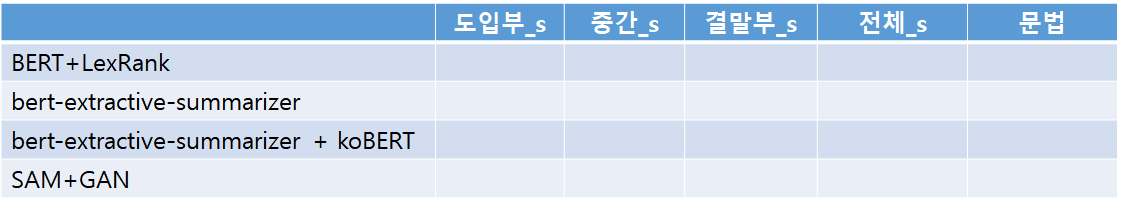

## 비교 대상 요약 알고리즘 준비

In [25]:
def similarity(query_text, org_text):
    sentences = nltk.sent_tokenize(org_text)
    print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(query_text)
    print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

def grammarity(text):
    
    input_ids = []
    attention_masks = []

    sentences = np.asarray(nltk.sent_tokenize(text))
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = g_discriminator.tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation = True,
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    g_discriminator.discriminator.to(device)
    #if str(discriminator1.device) == 'cpu':
    #    pass
    #else:
    #    input_ids = input_ids.to(device)
    #    attention_masks = attention_masks.to(device)        

    with torch.no_grad():        
        outputs = g_discriminator.discriminator(input_ids, 
                               token_type_ids=None, 
                               attention_mask=attention_masks)
    #return torch.sigmoid(outputs[0][:,1])
    return torch.mean(outputs[0][:,1]).detach().cpu().numpy()
    #return outputs

In [26]:
import pandas as pd
import numpy as np

def evaluate(method_name, text, org_text_1,org_text_2,org_text_3):
    result = {}
    result['method'] = [method_name]
    org_text = org_text_1 + ' ' + org_text_2 + ' ' + org_text_3
    result['comp ratio'] = len(text)/len(org_text)
    result['intro'] = [similarity(text,org_text_1)]
    result['body'] = [similarity(text,org_text_2)]
    result['ending'] = [similarity(text,org_text_3)]
    result['var'] = np.var([result['intro'][0],result['body'][0],result['ending'][0]])
    result['total'] = [similarity(text,org_text)]
    result['grammar'] = [np.tanh(float(grammarity(text)))]
    return pd.DataFrame(result),result

In [27]:
"""
LexRank implementation
Source: https://github.com/crabcamp/lexrank/tree/dev
"""

import numpy as np
from scipy.sparse.csgraph import connected_components

def degree_centrality_scores(
    similarity_matrix,
    threshold=None,
    increase_power=True,
):
    if not (
        threshold is None
        or isinstance(threshold, float)
        and 0 <= threshold < 1
    ):
        raise ValueError(
            '\'threshold\' should be a floating-point number '
            'from the interval [0, 1) or None',
        )

    if threshold is None:
        markov_matrix = create_markov_matrix(similarity_matrix)

    else:
        markov_matrix = create_markov_matrix_discrete(
            similarity_matrix,
            threshold,
        )

    scores = stationary_distribution(
        markov_matrix,
        increase_power=increase_power,
        normalized=False,
    )

    return scores


def _power_method(transition_matrix, increase_power=True):
    eigenvector = np.ones(len(transition_matrix))

    if len(eigenvector) == 1:
        return eigenvector

    transition = transition_matrix.transpose()

    while True:
        eigenvector_next = np.dot(transition, eigenvector)

        if np.allclose(eigenvector_next, eigenvector):
            return eigenvector_next

        eigenvector = eigenvector_next

        if increase_power:
            transition = np.dot(transition, transition)


def connected_nodes(matrix):
    _, labels = connected_components(matrix)

    groups = []

    for tag in np.unique(labels):
        group = np.where(labels == tag)[0]
        groups.append(group)

    return groups


def create_markov_matrix(weights_matrix):
    n_1, n_2 = weights_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'weights_matrix\' should be square')

    row_sum = weights_matrix.sum(axis=1, keepdims=True)

    return weights_matrix / row_sum


def create_markov_matrix_discrete(weights_matrix, threshold):
    discrete_weights_matrix = np.zeros(weights_matrix.shape)
    ixs = np.where(weights_matrix >= threshold)
    discrete_weights_matrix[ixs] = 1

    return create_markov_matrix(discrete_weights_matrix)


def graph_nodes_clusters(transition_matrix, increase_power=True):
    clusters = connected_nodes(transition_matrix)
    clusters.sort(key=len, reverse=True)

    centroid_scores = []

    for group in clusters:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        centroid_scores.append(eigenvector / len(group))

    return clusters, centroid_scores


def stationary_distribution(
    transition_matrix,
    increase_power=True,
    normalized=True,
):
    n_1, n_2 = transition_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'transition_matrix\' should be square')

    distribution = np.zeros(n_1)

    grouped_indices = connected_nodes(transition_matrix)

    for group in grouped_indices:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        distribution[group] = eigenvector

    if normalized:
        distribution /= n_1

    return distribution


* Hands-on Guide To Extractive Text Summarization With BERTSum<br>
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/ <br>
https://pypi.org/project/bert-extractive-summarizer/

In [28]:
!pip install bert-extractive-summarizer

In [29]:
from transformers import *

SQUAD_MODEL = "monologg/kobert"

# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained(SQUAD_MODEL)
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained(SQUAD_MODEL)
custom_model = AutoModel.from_pretrained(SQUAD_MODEL, config=custom_config)

In [30]:
def sam_wgan(org_text):
    source = Source(org_text[0] + org_text[1] + org_text[2])
    source.analysis_frame_terms(s_discriminator,comp_rate=0.08,except_key=True)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    summarizer.summarize(epochs=500,batch_size=1,frame_expansion_ratio = 1.0,init_bias=0.8,learning_rate=5e-5)
    summary_text = summarizer.get_summary(3)[0]
    print('-'*50)
    print('summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('SAM+WGAN',summary_text,org_text[0],org_text[1],org_text[2])
    return df,arr

In [31]:
def bert_lexrank_sum(org_text,n_top=8):
    input_text = org_text[0] + org_text[1] + org_text[2]
    #Split the document into sentences
    sentences = nltk.sent_tokenize(input_text)
    print("Num sentences:", len(sentences))

    #Compute the sentence embeddings
    embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    #util.pytorch_cos_sim(embeddings, embeddings).numpy()
    print(cos_scores)
    #Compute the centrality for each sentence
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    #We argsort so that the first element is the sentence with the highest score
    most_central_sentence_indices = np.argsort(-centrality_scores)

    #Print the 5 sentences with the highest scores
    summary_text = ""
    for idx in most_central_sentence_indices[0:n_top]:
        summary_text += sentences[idx].strip()

    df,arr = evaluate('BERT+LexRank',summary_text,org_text[0],org_text[1],org_text[2])
    return df,arr


In [32]:
from summarizer import Summarizer

def besm(org_text):
    model1 = Summarizer()
    result = model1(org_text[0] + org_text[1] + org_text[2], num_sentences=5)
    summary_text = "".join(result)
    df,arr = evaluate('BESM',summary_text,org_text[0],org_text[1],org_text[2])
    return df,arr

In [33]:
def besm_bert(org_text):
    model2 = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)
    result = model2(org_text[0] + org_text[1] + org_text[2], num_sentences=5)
    summary_text = "".join(result)
    df,arr = evaluate('BESM+kobert',summary_text,org_text[0],org_text[1],org_text[2])
    return df,arr

## CNN / Daily Mail 실험

In [34]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [35]:
def __crean_text(txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()

def clear_article(txt):
    article = []
    txt= __crean_text(txt)
    for l in txt.split('.'):
        if len(l) > 30:
            article += l+'.'
    txt = (''.join(article)).strip()
    pt = txt.split('.')
    lt = len(pt)
    intro_size = int(lt*0.2+0.5)
    body_size = int(lt*0.5+0.5)
    end_size = int(lt*0.3+0.5)
    print(intro_size,body_size,end_size)
    intro = pt[0:intro_size]
    body = pt[intro_size:intro_size+body_size]
    end = pt[intro_size+body_size:]
    #print(intro_size,body_size,end_size)
    #for l in txt.split('.'):
    
    return  ('.'.join(intro)).strip()+'.',('.'.join(body)).strip()+'.',('.'.join(end)).strip()

In [36]:
intro,body,end = clear_article(sentences_dataset[50])
print(intro)
print(body)
print(end)

4 10 6
Fears are growing that Britains jails are becoming a hotbed of extremism after it was revealed today that nearly half the inmates of one top security prison are Muslim. Some 42 per cent of those housed at Category A Whitemoor jail - and more than a quarter of those in London prisons - consider themselves to be of Islamic faith. Experts now fear large numbers are being radicalised on the inside, where they say the spread of Jihadist ideas is rife. Figures show more than a quarter of inmates in London jails are Muslim, with one Category A jail revealing 42 per cent of its convicts follow the Islamic faith.
Whitemoor inmate Zia Al Haq, left, was jailed for 18 for planning bomb attacks in London while Nezar Hindawi, right, was handed a 45-year sentence for plotting to blow up a jet. A source at Cambridgeshire jail Whitemoor told the Sunday People: Whitemoor is now effectively run by Muslims, many of whom are Jihadis. A 2012 probe into the jail branded it a Taliban recruiting ground 

In [74]:
org_text_1,org_text_2,org_text_3 = clear_article(sentences_dataset[4])


5 13 8


In [77]:
def sam_wgan(org_text):
    source = Source(org_text[0] + org_text[1] + org_text[2])
    source.analysis_frame_terms(s_discriminator,comp_rate=0.05,except_key=False)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    summarizer.summarize(epochs=500,batch_size=1,frame_expansion_ratio = 1.0,init_bias=0.3,learning_rate=5e-5)
    summary_text = summarizer.get_summary(3)[0]
    print('-'*50)
    print('summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('SAM+WGAN',summary_text,org_text[0],org_text[1],org_text[2])
    return df,arr,summary_text

------------------------------------------------------------------
Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top of the table. The Cod Army are playing in the third tier for the first time in their history after six promotions in nine years and their remarkable ascent shows no sign of slowing with Jamie Proctor and Gareth Evans scoring the goals at Glanford Park. Fleetwood were one of five teams to have won two out of two but the other four clubs - Peterborough, Bristol City, Chesterfield and Crawley - all hit their first stumbling blocks. Posh were defeated 2-1 by Sheffield United, who had lost both of their opening contests. Jose Baxter’s opener gave the Blades a first-half lead, and although it was later cancelled out by Shaun Brisley’s goal, Ben Davies snatched a winner six minutes from time. In the lead: Jose Baxter (right) celebrates opening the scoring for Sheffield United. Up for the ba

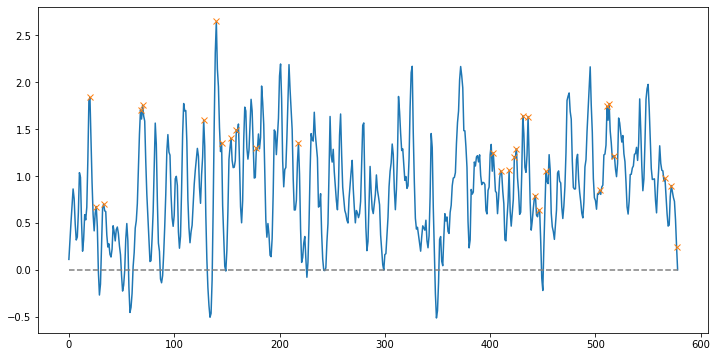

Peak count: 29
Frame text: win men Army scoring goals first-half goal, winner Baxter scoring keenly-contested Manchester goals helped victory. goals Coventry 2-2 goals McQuoid Clarke lead, Tom 2-1 victory Dawson Swindon Brancos net. 

Similarity : 0.4791296864217347
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, Generator / grammar loss:-0.08400053530931473   similarity loss:0.034851495176553726


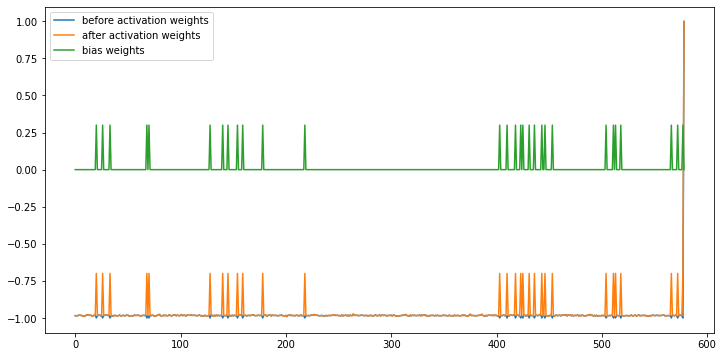

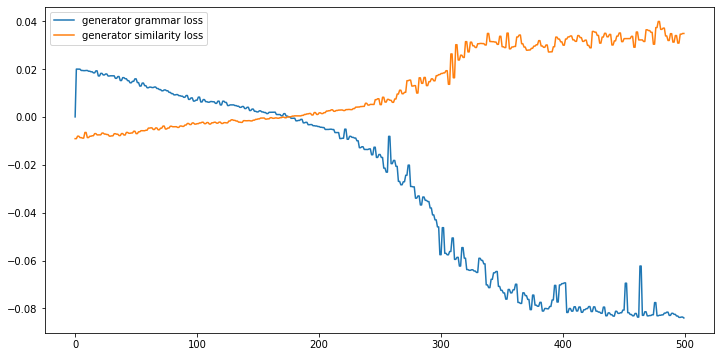

--------------------------------------------------
summary:
League win men Army first scoring goals teams to by United, first-half lead, goal, winner Baxter scoring challenges keenly-contested on Manchester time. lost Bantams. player up: are for the for were a goals helped away victory. goals Coventry Barnsley 2-2 goals half. McQuoid Clarke lead, from Colchester and Tom 2-1 victory Dawson last-minute the Swindon Brancos net. 
--------------------------------------------------
Num sentences: 5
Num querys: 5
Num sentences: 13
Num querys: 5
Num sentences: 7
Num querys: 5
Num sentences: 25
Num querys: 5
Num sentences: 23
[[0.00000000e+00 4.60276111e-01 5.32255738e-01 7.03835732e-01
  5.53645958e-01 6.86616079e-01 6.52965713e-01 6.98918303e-01
  6.14809806e-01 7.11661657e-01 7.92423664e-01 5.86915437e-01
  5.11531426e-01 7.72395586e-01 5.43749113e-01 5.21792643e-01
  6.75640934e-01 6.22677754e-01 8.69549059e-01 5.96385708e-01
  6.14526620e-01 5.65856604e-01 6.73814618e-01]
 [4.60276111e-01 

,method,comp ratio,intro,body,ending,var,total,grammar
0,SAM+WGAN,0.107674,0.436797,0.501882,0.555061,0.002339,0.503755,-0.999961
1,BERT+LexRank,0.246571,0.550202,0.508417,0.526028,0.000293,0.521705,0.999999
2,BESM,0.245404,0.697347,0.638925,0.444229,0.011710,0.596094,0.999999
3,BESM+kobert,0.244529,0.718832,0.668002,0.475738,0.010960,0.624334,0.999999


In [75]:
df1,_,sum = sam_wgan([org_text_1,org_text_2,org_text_3])
df2,_ = bert_lexrank_sum([org_text_1,org_text_2,org_text_3])
df3,_ = besm([org_text_1,org_text_2,org_text_3])
df4,_ = besm_bert([org_text_1,org_text_2,org_text_3])
result = pd.concat([df1, df2, df3, df4 ], ignore_index=True)
result


Test용 Data 준비

In [76]:
document = []
real_sum = []
for i,doc in zip(range(len(sentences_dataset[0:5])),sentences_dataset[0:5]):
    intro,body,end = clear_article(doc)
    document.append([intro,body,end])
    real_sum.append(gold_summary[i])

print(len(document))

print(document[0])
print(real_sum[0])


2 5 3
4 10 6
8 19 11
4 11 7
5 13 8
5
['The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion.', 'Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A. State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, tir

In [62]:
print(document[0])
print(real_sum[0])


['The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion.', 'Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A. State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and 

1 / 5
------------------------------------------------------------------
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A. State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of

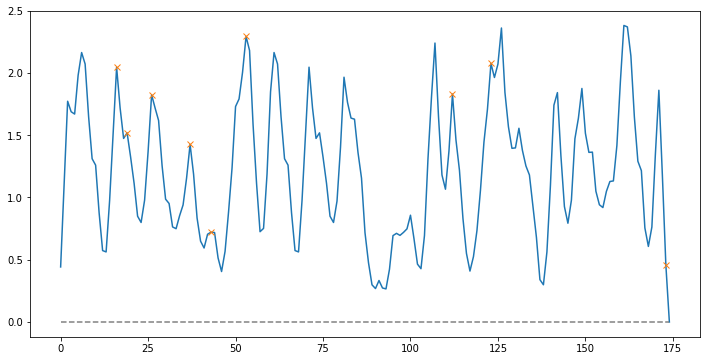

Peak count: 9
Frame text: church Fargo, hepatitis Health of communion. Bishop hepatitis located. 

Similarity : 0.41104593348240137
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, Generator / grammar loss:-0.01116974838078022   similarity loss:0.0027046941686421633


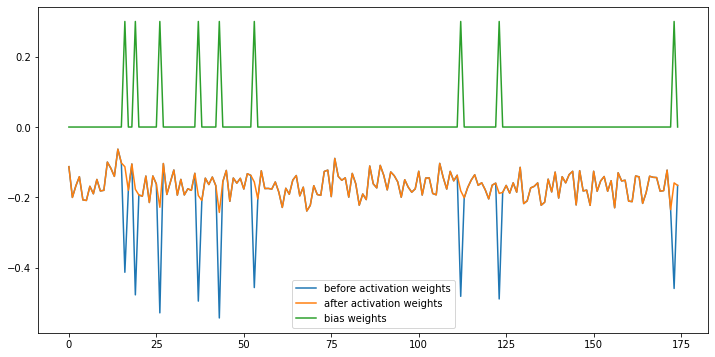

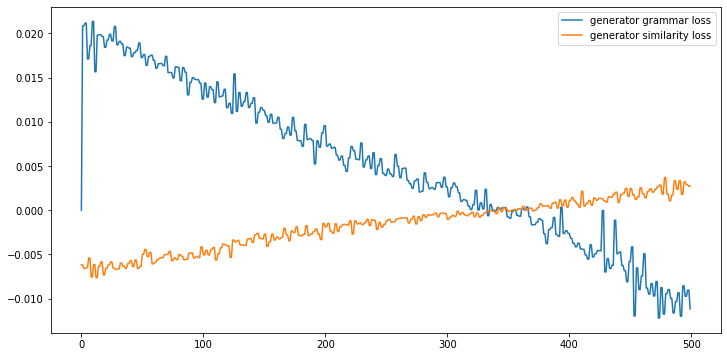

--------------------------------------------------
summary:
 bishop in September who and Forks to Molly says that diagnosed food in tiredness, loss Diocese (pictured)
--------------------------------------------------
Num sentences: 2
Num querys: 1
Num sentences: 5
Num querys: 1
Num sentences: 1
Num querys: 1
Num sentences: 8
Num querys: 1
Num sentences: 6
[[0.         0.32593626 0.90184845 0.59175008 0.72949636 0.33934876]
 [0.32593626 0.         0.79083937 0.60092852 0.66784547 0.54210916]
 [0.90184845 0.79083937 0.         0.94862865 0.88458002 0.86573581]
 [0.59175008 0.60092852 0.94862865 0.         0.65849989 0.60162723]
 [0.72949636 0.66784547 0.88458002 0.65849989 0.         0.74647206]
 [0.33934876 0.54210916 0.86573581 0.60162723 0.74647206 0.        ]]
Num sentences: 2
Num querys: 1
Num sentences: 5
Num querys: 1
Num sentences: 1
Num querys: 1
Num sentences: 8
Num querys: 1
Num sentences: 2
Num querys: 6
Num sentences: 5
Num querys: 6
Num sentences: 1
Num querys: 6
Num sente

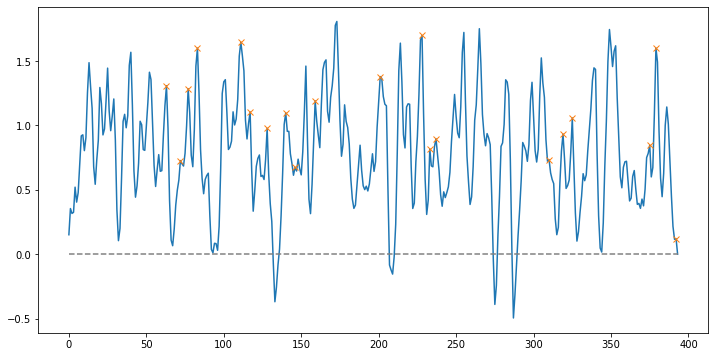

Peak count: 20
Frame text: accuses using police trafficking dealers. cops, complaint. plot, payment complaint Court narcotics Ecuador Republic working Miami complaint. Florida convicted, report. 

Similarity : 0.38638745233830407
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, Generator / grammar loss:-0.06167351081967354   similarity loss:0.022497601807117462


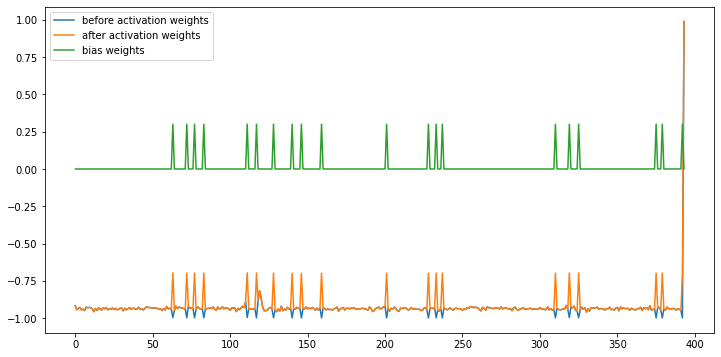

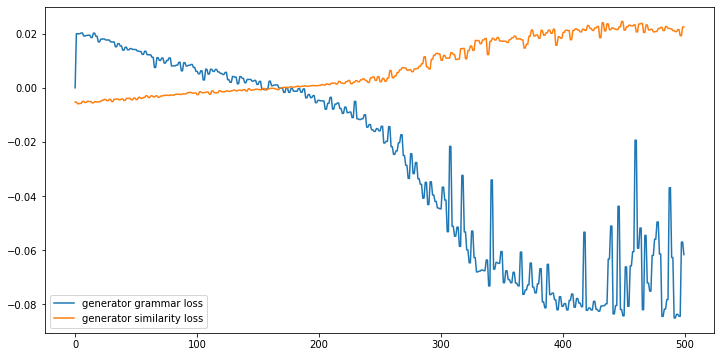

--------------------------------------------------
summary:
for accuses also using police trafficking In instance, kill drug dealers. cops, pulling over their complaint. plot, payment setting complaint transport Court with allegedly has narcotics Ecuador Republic Tuesday not Department working Miami according complaint. from Florida convicted, report. 
--------------------------------------------------
Num sentences: 4
Num querys: 4
Num sentences: 10
Num querys: 4
Num sentences: 5
Num querys: 4
Num sentences: 19
Num querys: 4
Num sentences: 17
[[0.00000000e+00 7.31878345e-01 7.45443690e-01 6.05202038e-01
  6.44495002e-01 7.40497294e-01 5.86788074e-01 5.98939642e-01
  5.96876689e-01 6.44569230e-01 6.13836608e-01 6.89582239e-01
  3.95421259e-01 7.56364311e-01 9.04848843e-01 9.03806656e-01
  6.66711098e-01]
 [7.31878345e-01 0.00000000e+00 9.15161871e-01 6.59359638e-01
  5.44704819e-01 7.94436021e-01 5.46824088e-01 5.84435399e-01
  7.98857890e-01 7.16560382e-01 9.19851898e-01 9.34322280e-0

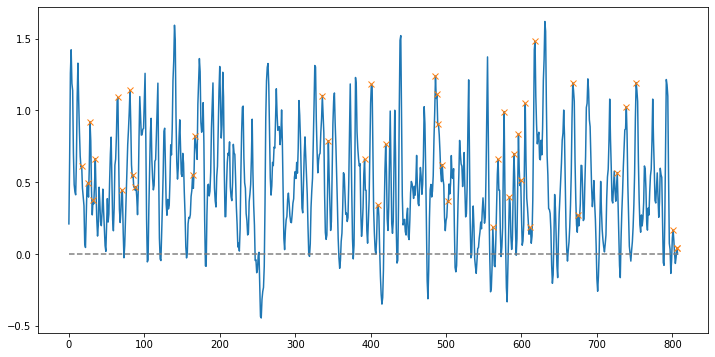

Peak count: 41
Frame text: phone Eccleston-Todd, driving night pub car Craig crashed car driven friends pub ‘Miss danger over hit near phone collision sadly cost Eccleston-Todd met limit, over collision judge phone texting phone collision would driving drinking wheel, Eccleston-Todd lost drinking have re-test. re-test. 

Similarity : 0.3640850685966419
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, Generator / grammar loss:-0.08626461774110794   similarity loss:0.027266476303339005


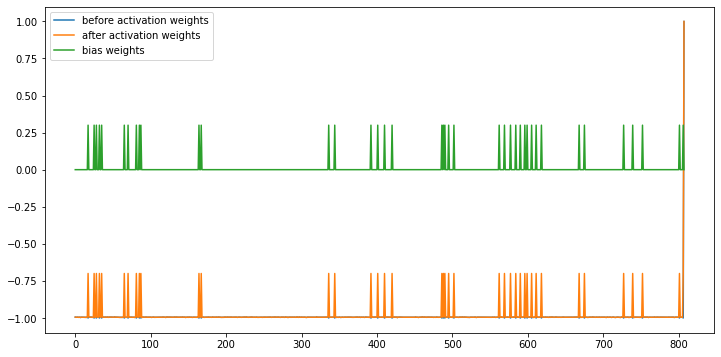

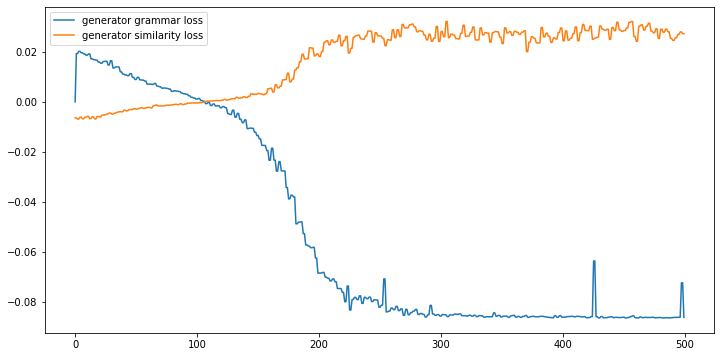

--------------------------------------------------
summary:
phone Eccleston-Todd, driving night pub when received veered car Craig crashed car driven had He friends pub was Eccleston-Todd’s avoided. either he bend, car. her her. She home that ‘Miss in danger Police take tests over hit on near of phone evening, any the collision sadly it cost Eccleston-Todd met limit, over limit collision today, judge agreed. phone texting phone of collision so would driving control. death spend six I will drinking wheel, who of Eccleston-Todd lost drinking how have re-test. 
--------------------------------------------------
Num sentences: 8
Num querys: 6
Num sentences: 19
Num querys: 6
Num sentences: 10
Num querys: 6
Num sentences: 37
Num querys: 6
Num sentences: 35
[[0.         0.64169255 0.59460802 ... 0.68178138 0.86312992 0.72412523]
 [0.64169255 0.         0.65996009 ... 0.80507608 1.0429115  0.72306599]
 [0.59460802 0.65996009 0.         ... 0.58836245 0.86888705 0.61157917]
 ...
 [0.68178138 0.

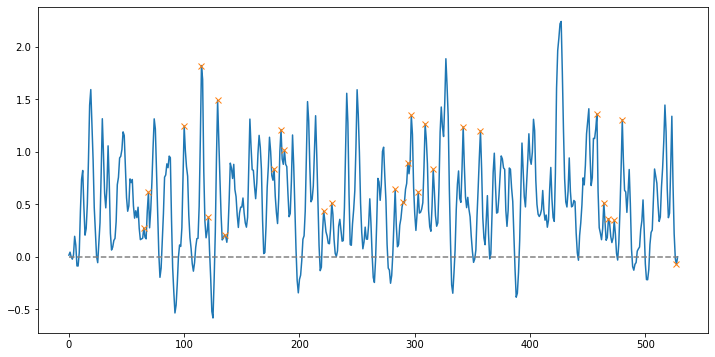

Peak count: 27
Frame text: quick Europes Europe Russian logic Russia two money freezes restrictions like Hermitage Moscow Yet money Europe consequences EU sanctions Putin. EU Russian hard factories without Putin wane. 

Similarity : 0.40470950289483365
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, Generator / grammar loss:-0.08518876880407333   similarity loss:0.027888288721442223


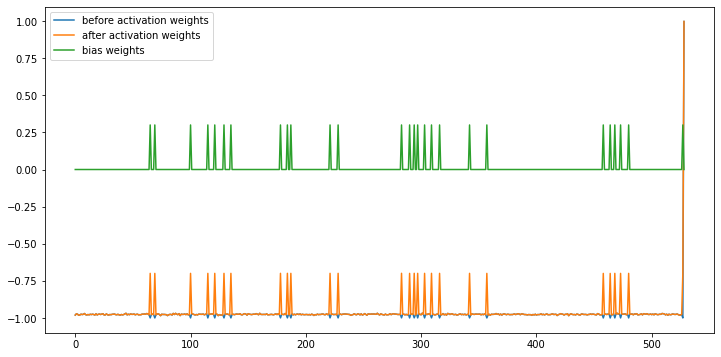

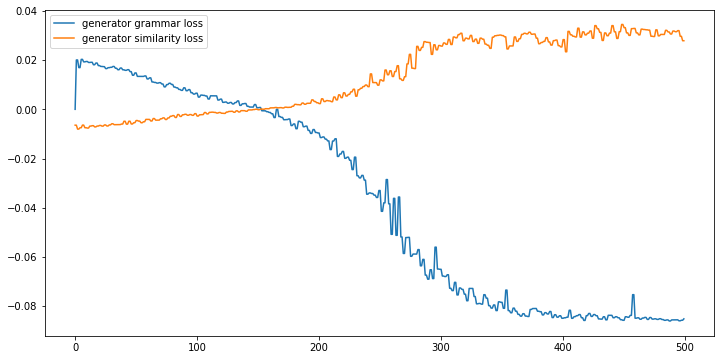

--------------------------------------------------
summary:
near quick Europes Europe is Russian particular. logic of Russia two Navalny, Abramovich money freezes restrictions the like Hermitage and adoption law Moscow Yet money Europe consequences EU must sanctions Putin. strategy to EU patronage, like Picasso years. rapprochement and that hurt Russian - a hard factories without Putin channels all lifeline, wane. 
--------------------------------------------------
Num sentences: 4
Num querys: 4
Num sentences: 11
Num querys: 4
Num sentences: 6
Num querys: 4
Num sentences: 21
Num querys: 4
Num sentences: 19
[[0.00000000e+00 4.89001780e-01 7.97913602e-01 6.59639275e-01
  7.26321941e-01 6.85086760e-01 7.47398185e-01 9.00038235e-01
  7.44685733e-01 7.23565341e-01 7.73221100e-01 8.58853137e-01
  6.85247260e-01 8.19034414e-01 8.66091561e-01 8.44768617e-01
  8.82700485e-01 6.23541401e-01 7.94164100e-01]
 [4.89001780e-01 0.00000000e+00 8.08441686e-01 8.03648517e-01
  6.42964007e-01 8.40687830e

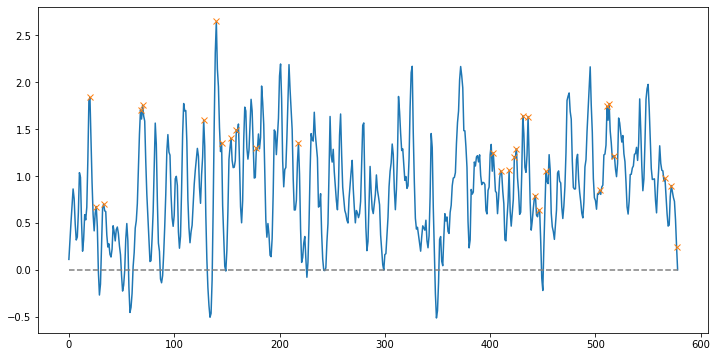

Peak count: 29
Frame text: win men Army scoring goals first-half goal, winner Baxter scoring keenly-contested Manchester goals helped victory. goals Coventry 2-2 goals McQuoid Clarke lead, Tom 2-1 victory Dawson Swindon Brancos net. 

Similarity : 0.4791296864217347
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, Generator / grammar loss:-0.08394607901573181   similarity loss:0.034381214529275894


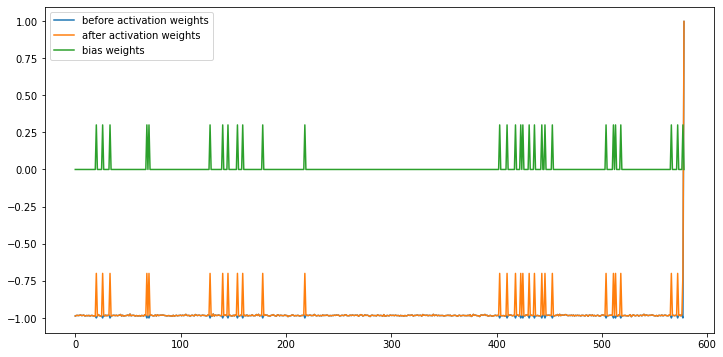

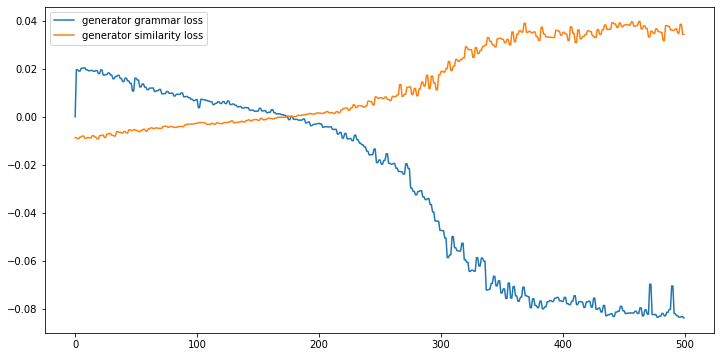

--------------------------------------------------
summary:
team win men top Army time years their scoring goals at Glanford Blades first-half although goal, winner Baxter scoring challenges keenly-contested Bristol Manchester Capital Crawley this minutes Orients a Bradford whom the goals helped victory. goals Coventry 2-2 goals McQuoid Clarke lead, a recorded replied for Tom 2-1 victory Dawson after Hayter Gillingham to Swindon Brancos net. 
--------------------------------------------------
Num sentences: 5
Num querys: 2
Num sentences: 13
Num querys: 2
Num sentences: 7
Num querys: 2
Num sentences: 25
Num querys: 2
Num sentences: 23
[[0.00000000e+00 4.60276111e-01 5.32255738e-01 7.03835732e-01
  5.53645958e-01 6.86616079e-01 6.52965713e-01 6.98918303e-01
  6.14809806e-01 7.11661657e-01 7.92423664e-01 5.86915437e-01
  5.11531426e-01 7.72395586e-01 5.43749113e-01 5.21792643e-01
  6.75640934e-01 6.22677754e-01 8.69549059e-01 5.96385708e-01
  6.14526620e-01 5.65856604e-01 6.73814618e-01]


In [79]:
test_result = {}
test_result['SAM+WGAN']=[]
test_result['BERT+LexRank']=[]
test_result['BESM']=[]
test_result['BESM+kobert']=[]
test_sum = []

step = 0
for intro,body,end in document:
    step += 1
    print("=" * 50)
    print(str(step),"/",len(document))
    print("=" * 50)
    
    org_text_1 = intro
    org_text_2 = body
    org_text_3 = end
    try:
        df1,dct1,sum = sam_wgan([org_text_1,org_text_2,org_text_3])
        test_sum.append(sum)
        df2,dct2 = bert_lexrank_sum([org_text_1,org_text_2,org_text_3])
        df3,dct3 = besm([org_text_1,org_text_2,org_text_3])
        df4,dct4 = besm_bert([org_text_1,org_text_2,org_text_3])
        test_result['SAM+WGAN'].append([dct1['comp ratio'],dct1['intro'][0],dct1['body'][0],dct1['ending'][0],dct1['var'],dct1['total'][0],dct1['grammar'][0]])
        test_result['BERT+LexRank'].append([dct2['comp ratio'],dct2['intro'][0],dct2['body'][0],dct2['ending'][0],dct2['var'],dct2['total'][0],dct2['grammar'][0]])
        test_result['BESM'].append([dct3['comp ratio'],dct3['intro'][0],dct3['body'][0],dct3['ending'][0],dct3['var'],dct3['total'][0],dct3['grammar'][0]])
        test_result['BESM+kobert'].append([dct4['comp ratio'],dct4['intro'][0],dct4['body'][0],dct4['ending'][0],dct4['var'],dct4['total'][0],dct4['grammar'][0]])
        result = pd.concat([df1, df2, df3, df4 ], ignore_index=True)
        print(result)
    except:
        print('Error!!! skip~')


In [80]:
df_data = {}
df_data['method'] = []
df_data['comp rate'] = []
df_data['intro'] = []
df_data['body'] = []
df_data['conclusion'] = []
df_data['isthmus'] = []
df_data['simlirality'] = []
df_data['grammarity'] = []
for key in test_result:
    df_data['method'].append(key)
    data = np.asarray(test_result[key])
    df_data['comp rate'].append(np.mean(data[:,0]))
    df_data['intro'].append(np.mean(data[:,1]))
    df_data['body'].append(np.mean(data[:,2]))
    df_data['conclusion'].append(np.mean(data[:,3]))
    df_data['isthmus'].append(np.mean(data[:,4]))
    df_data['simlirality'].append(np.mean(data[:,5]))
    df_data['grammarity'].append(np.mean(data[:,6]))

df = pd.DataFrame(df_data)
df

,method,comp rate,intro,body,conclusion,isthmus,simlirality,grammarity
0,SAM+WGAN,0.109217,0.399763,0.431279,0.379477,0.002493,0.416386,-0.999970
1,BERT+LexRank,0.405497,0.415331,0.438118,0.326768,0.007355,0.413441,0.999999
2,BESM,0.324689,0.664755,0.627585,0.617749,0.005156,0.628722,0.999976
3,BESM+kobert,0.335793,0.777203,0.596654,0.603942,0.012396,0.629908,0.999998


Table2는 비교적 짧은 스토리에 대한 요약 방법별 결과 비교를 나타낸다.'comp ratio'는 요약의 압축율을 나타낸다. comp ration가 낮을 수록 요약의 압축이 많이 되었다는 의미있다. 비교 검증의 신뢰성을 위하여 가능한 comp ratio을 비슷하게 맞추었다. 아래의 표에서 알 수 있듯이, 비교적 짧은 문서에 대해서는 추출방법 대비 지협성 해소의 효과가 크게 나타나지 않는 것을 확인 할 수 있다. 결과적으로 추출 방법에 비해 유사성의 큰 변화가 없었다. 하지만, Table3의 비교적 긴 스토리에 대한 요약 방법별 결과 비교에서 보면, 제안의 방법이 추출 방법 대비 압축율 이 가장 낮음에도 불구하고  지협성 해소의 효과가 있음을 확인 할 수 있다. 서론, 본론, 결론의 각 유사성이 다른 방법에 비해 고르게 분포하고 있다. 또한 그림 4의 분포도에서 서론, 본론, 결론의 각 유사성의 편차가 제안 방법이 가장 낮게 나타나고 있음을 확인할 수 있었다. 

Table 2 shows the comparison of results by summary method for relatively short stories. 'comp ratio' indicates the compression ratio of the summary. The lower the comp ration, the more the summary is compressed. For the reliability of the comparison verification, the comp ratio was similarly adjusted with other method. As can be seen from the table below, it shows that for relatively short stories (document), the effect of resolving isthmus compared to the extractive method does not appear much. As a result, there was no significant change in summarization similarity compared to the extractive method. However, from the comparison of the results of each summary method for the relatively long story in Table 3, it shows that the proposed method has the effect of resolving isthmus, although the compression ratio is the lowest compared to the extractive method. The similarities of the introduction, body, and conclusion are evenly distributed compared to other methods. In addition, in the distribution map of Fig. 4, it was confirmed that the deviation of the similarity between the introduction, the body, and the conclusion was the lowest in the proposed method.

## rouge metrix

In [65]:
!pip install rouge-score

In [69]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [70]:
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rouge2': Score(precision=0.2857142857142857, recall=0.25, fmeasure=0.26666666666666666),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [81]:
for real,test in zip(real_sum,test_sum):
    scores = scorer.score(real,test)
    print(scores)

{'rouge1': Score(precision=0.4117647058823529, recall=0.20588235294117646, fmeasure=0.2745098039215686), 'rouge2': Score(precision=0.0625, recall=0.030303030303030304, fmeasure=0.04081632653061225), 'rougeL': Score(precision=0.23529411764705882, recall=0.11764705882352941, fmeasure=0.15686274509803924)}
{'rouge1': Score(precision=0.23076923076923078, recall=0.2571428571428571, fmeasure=0.24324324324324323), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1282051282051282, recall=0.14285714285714285, fmeasure=0.13513513513513511)}
{'rouge1': Score(precision=0.3448275862068966, recall=0.42857142857142855, fmeasure=0.3821656050955414), 'rouge2': Score(precision=0.011627906976744186, recall=0.014492753623188406, fmeasure=0.012903225806451613), 'rougeL': Score(precision=0.16091954022988506, recall=0.2, fmeasure=0.178343949044586)}
{'rouge1': Score(precision=0.2692307692307692, recall=0.27450980392156865, fmeasure=0.27184466019417475), 'rouge2': Score(pr

# 6. Conclution

본 논문에서 제안한 방법은 extractive 방법의 지협성을 해결 할 수 있었고, abstractive 방법에서 필요한 대량의 학습셋 없이도 WGAN의 비지도 학습에 의해서 abstractive의 효과를 얻을 수 있었다. 
 원문대비 유사성에 있어서는 비교적 짧은 스토리에서 Extractive 방법과 대등소이한 결과를 보였으나, 비교적 긴 스토리에서는 Extractive보다 Similarity가 서론, 본문, 결론 모두 높게 나타났다. 그러나, grammarlity는 가장 낮았다. 이는, 주요 어절을 기반으로 문법에 맞게 적당한 어절을 만들어내는 기본 알고리즘 구조상 나타나는 현상으로 이해할 수 있다.
 일반 DNN구조로 만들어진 Generator이기 때문에 문법 구성이 부드럽지 못했다. 향후에는 seq2seq 알고리즘으로 Generator를 구성하면 문법적으로 더 완성도 높은 문장을 생성할 것으로 기대한다. 

The method proposed in this paper was able to solve the isthmus of the extractive method, and obtained the abstractive effect by the unsupervised learning of WGAN without the need for a large number of training sets required in the abstractive method. In terms of similarity compared to the original text, the results were comparable to the extractive method in a relatively short story, but the similarity was higher in the introduction, body, and conclusion than in extractive in a relatively long story. However, the grammarlity was the lowest. This can be understood as a phenomenon that appears in the structure of a basic algorithm that generates words appropriate for grammar based on major words. Since it is a generator made with a general DNN structure, the grammar composition was not smooth. In the future, if the generator is configured with the seq2seq algorithm, it is expected that sentences with higher grammatical completion will be generated.

## Reference

[1] Rada Mihalcea and Paul Tarau, (2004). TextRank: Bringing Order into Texts <br>
[2] G¨une¸s Erkan. (2004). LexRank: Graph-based Lexical Centrality as Salience in Text Summarization <br>
[3] Susan T. Dumais (2005). "Latent Semantic Analysis". Annual Review of Information Science and Technology. 38: 188–230. <br>
[4] Hans Peter Luhn (1960). Keyword-in-context index for technical literature. American Documentation, 11(4):288–295. ISSN 0002-823 <br>
[5] Aria Haghighi, (2009). Exploring Content Models for Multi-Document Summarization <br>
[6] Colin Raffel. (2020). Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer <br>
[7] Mike Lewis, (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension <br>
[8] Alec Radford, (2018). Language Models are Unsupervised Multitask Learners <br>
[9] Guillaume Lample, (2019). Cross-lingual Language Model Pretraining <br>
[10] Nils Reimers and Iryna Gurevych, (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks <br>
[11] Sharma, P., & Li, Y. (2019). Self-Supervised Contextual Keyword and Keyphrase Retrieval with Self-Labelling <br>
[12] Jacob Devlin, (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding <br>
[13] Ian J. Goodfellow, (2014). Generative Adversarial Nets <br>
[14] Yau-ShianWang, (2018). Learning to Encode Text as Human-Readable Summaries using Generative Adversarial Networks <br>
[15] Martin Arjovsky, (2017). Wasserstein GAN <br>